In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ema_workbench import load_results
from importlib import reload

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import _tree
import subprocess
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from scipy.spatial import distance_matrix

import matplotlib.cm as cm
from dtreeviz.trees import *

import clustering_helper as ch

## Data prep

In [2]:
results = load_results('sim_results.tar.gz')
experiments, outcomes = results

outcomes_df = pd.DataFrame(outcomes)
experiments_df = pd.DataFrame(experiments)

results_df = outcomes_df.join(experiments_df)
results_df = results_df[results_df.columns[23:46]]

In [3]:
for col in ['TE','clim_scen','lud_scen','pol_dike_switch_ag','pol_dike_switch_dt','pol_fer','pol_seed']:
    experiments_df[col] = experiments_df[col].astype(int)

In [4]:
#one-hot encoder for lud_scen
for scen in np.unique(experiments_df['lud_scen']):
    experiments_df['lud_scen_{}'.format(scen)] = experiments_df['lud_scen']==scen
    experiments_df['lud_scen_{}'.format(scen)] = experiments_df['lud_scen_{}'.format(scen)].astype(int)    
del experiments_df['lud_scen']

#one-hot encoder for pol_dike_switch_ag
for scen in np.unique(experiments_df['pol_dike_switch_ag']):
    if scen > 0:
        experiments_df['pol_dike_switch_ag_{}'.format(scen)] = experiments_df['pol_dike_switch_ag']==scen
        experiments_df['pol_dike_switch_ag_{}'.format(scen)] = experiments_df['pol_dike_switch_ag_{}'.format(scen)].astype(int)    
del experiments_df['pol_dike_switch_ag']

#one-hot encoder for pol_dike_switch_dt
for scen in np.unique(experiments_df['pol_dike_switch_dt']):
    if scen > 0:
        experiments_df['pol_dike_switch_dt_{}'.format(scen)] = experiments_df['pol_dike_switch_dt']==scen
        experiments_df['pol_dike_switch_dt_{}'.format(scen)] = experiments_df['pol_dike_switch_dt_{}'.format(scen)].astype(int)    
del experiments_df['pol_dike_switch_dt']

#one-hot encoder for pol_fer
experiments_df['pol_fer'] /= 3

In [5]:
results_standardized = results_df.copy()

for i in range(len(results_standardized)):
    results_standardized.iloc[i] = [x[0] for x in StandardScaler().\
                                    fit_transform(results_standardized.iloc[i].values.reshape(-1, 1))]

## Multivariate tree regressor

In [6]:
try:
    del experiments_df['scenario']
    del experiments_df['policy']
    del experiments_df['model']
except:
    pass

X_train = experiments_df.copy()
y_train = results_standardized.copy()

X_train['pol_fer'] = X_train['pol_fer'].astype(int)

In [7]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [8]:
crossval_master = pd.DataFrame()
for i in range(3,40):
    crossval_ = pd.DataFrame()
    regressor = DecisionTreeRegressor(random_state=0, max_leaf_nodes=i)
    crossval_['score'] = cross_val_score(regressor, X_train, y_train, cv=k_fold)
    crossval_['leaves'] = i
    crossval_master = crossval_master.append(crossval_)

In [11]:
mean_crossval = crossval_master.pivot_table(values='score', columns='leaves').values[0]
res = [y-x for x, y in zip(mean_crossval, mean_crossval[1:])]

inc_crossval = pd.DataFrame()
inc_crossval['leaves'] = np.unique(crossval_master['leaves'])[1:]
inc_crossval['increment_score'] = res

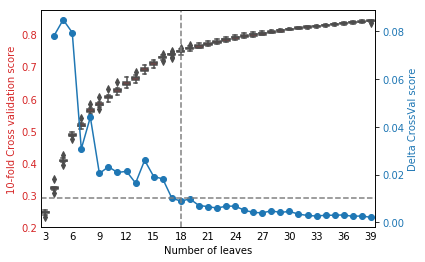

In [13]:
fig, ax1 = plt.subplots(figsize=(6,4))

thresval = 0.01
        
color = 'tab:red'
sns.boxplot(x='leaves', y='score', data=crossval_master, color=color, ax=ax1)
ax1.set_xlabel('Number of leaves')
ax1.set_ylabel('10-fold Cross validation score', color=color)
ax1.tick_params(axis='y', labelcolor=color)
for label in ax1.xaxis.get_ticklabels():
    label.set_visible(False)
for label in ax1.xaxis.get_ticklabels()[::3]:
    label.set_visible(True)
ax1.tick_params(axis=u'both', which=u'both',length=0)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Delta CrossVal score', color=color)  # we already handled the x-label with ax1
ax2.plot([x+1 for x in range(len(inc_crossval))], inc_crossval['increment_score'], color=color, marker='o')
ax2.axhline(y=thresval, color='grey', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
index_threshold = inc_crossval.loc[inc_crossval['increment_score']<thresval]['leaves'].min()

ax2.axvline(x=index_threshold-3,color='grey', linestyle='--')

In [14]:
#swap policy variables 0-1 for visualization purpose
for col in X_train.columns:
    if 'pol' in col:
        X_train[col] = 1-X_train[col]

In [15]:
regressor = DecisionTreeRegressor(random_state=0, max_leaf_nodes=18)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=18, random_state=0)

## Generating decision tree

In [18]:
'''
codes for generating decision rules
'''
n_nodes = regressor.tree_.node_count
children_left = regressor.tree_.children_left
children_right = regressor.tree_.children_right
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold

def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)
        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False


def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        #We check if we are not in the leaf
        if index!=len(path)-1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

# Leaves
leave_id = regressor.apply(X_train)

paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule(paths[key], experiments_df.columns)

In [19]:
rules

{10: "(df['pol_dike_switch_ag_1']> 0.5) & (df['TE']> 4.5) & (df['pol_dike_switch_ag_2']> 0.5)  ",
 11: "(df['pol_dike_switch_ag_1']> 0.5) & (df['TE']<= 4.5) & (df['pol_dike_switch_dt_1']<= 0.5) & (df['TE']<= 1.5)  ",
 13: "(df['pol_dike_switch_ag_1']<= 0.5) & (df['TE']<= 2.5) & (df['pol_dike_switch_dt_2']<= 0.5)  ",
 18: "(df['pol_dike_switch_ag_1']> 0.5) & (df['TE']<= 4.5) & (df['pol_dike_switch_dt_1']> 0.5) & (df['pol_dike_switch_ag_2']> 0.5) & (df['TE']> 3.5)  ",
 19: "(df['pol_dike_switch_ag_1']<= 0.5) & (df['TE']> 2.5) & (df['pol_dike_switch_dt_1']<= 0.5)  ",
 21: "(df['pol_dike_switch_ag_1']<= 0.5) & (df['TE']> 2.5) & (df['pol_dike_switch_dt_1']> 0.5) & (df['TE']<= 4.5)  ",
 22: "(df['pol_dike_switch_ag_1']<= 0.5) & (df['TE']> 2.5) & (df['pol_dike_switch_dt_1']> 0.5) & (df['TE']> 4.5)  ",
 23: "(df['pol_dike_switch_ag_1']> 0.5) & (df['TE']> 4.5) & (df['pol_dike_switch_ag_2']<= 0.5) & (df['pol_dike_switch_dt_2']<= 0.5)  ",
 24: "(df['pol_dike_switch_ag_1']> 0.5) & (df['TE']> 4.5) 

In [20]:
#exporting GraphViz
import sklearn
reload(sklearn)

import subprocess

sklearn.tree.export_graphviz(regressor, label='all', impurity=False, precision=1, feature_names=X_train.columns, filled=False,
                leaves_parallel=True, out_file='mvtree_full.dot', show_value=False)

In [21]:
#generating full tree figure
subprocess.call('dot -Tpng mvtree_ful.dot -o mvtree_full.png -Gdpi=500')

0

In [22]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names))) 

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, node))

    recurse(0, 1)

In [23]:
tree_to_code(regressor, experiments_df.columns)

def tree(yield_adjust_AW_scaling, yield_adjust_SA_scaling, TE, clim_scen, pol_fer, pol_seed, lud_scen_1, lud_scen_2, lud_scen_3, lud_scen_4, pol_dike_switch_ag_1, pol_dike_switch_ag_2, pol_dike_switch_dt_1, pol_dike_switch_dt_2):
    if pol_dike_switch_ag_1 <= 0.5:
        if TE <= 2.5:
            if pol_dike_switch_dt_2 <= 0.5:
                return 13
            else:  # if pol_dike_switch_dt_2 > 0.5
                if pol_dike_switch_dt_1 <= 0.5:
                    return 31
                else:  # if pol_dike_switch_dt_1 > 0.5
                    return 32
        else:  # if TE > 2.5
            if pol_dike_switch_dt_1 <= 0.5:
                return 19
            else:  # if pol_dike_switch_dt_1 > 0.5
                if TE <= 4.5:
                    return 21
                else:  # if TE > 4.5
                    return 22
    else:  # if pol_dike_switch_ag_1 > 0.5
        if TE <= 4.5:
            if pol_dike_switch_dt_1 <= 0.5:
                if TE <= 1.5:
            

In [24]:
def define_class(_):
    yield_adjust_AW_scaling, yield_adjust_SA_scaling, TE, clim_scen, pol_fer, pol_seed, \
    lud_scen_1, lud_scen_2, lud_scen_3, lud_scen_4, pol_dike_switch_ag_1, pol_dike_switch_ag_2,\
    pol_dike_switch_dt_1, pol_dike_switch_dt_2 = _
    if pol_dike_switch_ag_1 <= 0.5:
        if TE <= 2.5:
            if pol_dike_switch_dt_2 <= 0.5:
                return 13
            else:  # if pol_dike_switch_dt_2 > 0.5
                if pol_dike_switch_dt_1 <= 0.5:
                    return 31
                else:  # if pol_dike_switch_dt_1 > 0.5
                    return 32
        else:  # if TE > 2.5
            if pol_dike_switch_dt_1 <= 0.5:
                return 19
            else:  # if pol_dike_switch_dt_1 > 0.5
                if TE <= 4.5:
                    return 21
                else:  # if TE > 4.5
                    return 22
    else:  # if pol_dike_switch_ag_1 > 0.5
        if TE <= 4.5:
            if pol_dike_switch_dt_1 <= 0.5:
                if TE <= 1.5:
                    return 11
                else:  # if TE > 1.5
                    if TE <= 3.5:
                        return 33
                    else:  # if TE > 3.5
                        return 34
            else:  # if pol_dike_switch_dt_1 > 0.5
                if pol_dike_switch_ag_2 <= 0.5:
                    if pol_dike_switch_dt_2 <= 0.5:
                        return 27
                    else:  # if pol_dike_switch_dt_2 > 0.5
                        if TE <= 2.5:
                            return 29
                        else:  # if TE > 2.5
                            return 30
                else:  # if pol_dike_switch_ag_2 > 0.5
                    if TE <= 3.5:
                        if pol_dike_switch_dt_2 <= 0.5:
                            return 25
                        else:  # if pol_dike_switch_dt_2 > 0.5
                            return 26
                    else:  # if TE > 3.5
                        return 18
        else:  # if TE > 4.5
            if pol_dike_switch_ag_2 <= 0.5:
                if pol_dike_switch_dt_2 <= 0.5:
                    return 23
                else:  # if pol_dike_switch_dt_2 > 0.5
                    return 24
            else:  # if pol_dike_switch_ag_2 > 0.5
                return 10

In [25]:
classes = X_train.apply(lambda x: define_class([x[col] for col in X_train.columns]), axis=1)

In [26]:
np.unique(classes, return_counts=True)

(array([10, 11, 13, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33,
        34], dtype=int64),
 array([2400, 3200, 2400, 1600, 2400, 3200, 1600,  800, 1600, 3200, 3200,
        4000, 2400, 1600, 2400, 2400, 3200, 1600], dtype=int64))

## Visualization

In [27]:
dtag_gdf = ch.append_to_gdf(classes, results_df)

In [28]:
# #left branch
# labels = [13, 31, 32, 19, 21, 22]
# fig, axes = plt.subplots(1,len(labels), figsize=(18,2))
# row, col = 0,0

# for i, cluster in enumerate(labels):
#     name = 'cluster_' + str(cluster)
#     dtag_gdf.plot(column=name, legend=False, ax=axes[i], cmap='Greens', linewidth=0.3, edgecolor='black')
#     axes[i].get_xaxis().set_visible(False)
#     axes[i].get_yaxis().set_visible(False)
#     axes[i].axis('off')
#     axes[i].set_title('Cluster ' + str(i+1))
# plt.savefig('figs/iEMSs/MRT_left_branch.jpeg', dpi=500, bbox_inches='tight')

In [29]:
# #right branch
# labels = [11, 33, 34, 27, 29, 30, 25, 26, 18, 23, 24, 10]
# fig, axes = plt.subplots(1,len(labels), figsize=(36,2))
# row, col = 0,0

# for i, cluster in enumerate(labels):
#     name = 'cluster_' + str(cluster)
#     dtag_gdf.plot(column=name, legend=False, ax=axes[i], cmap='Greens', linewidth=0.3, edgecolor='black')
#     axes[i].get_xaxis().set_visible(False)
#     axes[i].get_yaxis().set_visible(False)
#     axes[i].axis('off')
#     axes[i].set_title('Cluster ' + str(i+7))
# plt.savefig('figs/iEMSs/MRT_right_branch.jpeg', dpi=500, bbox_inches='tight')

In [30]:
#use medoid of each cluster, instead mean

labels_used = classes

results_cluster_medoid = pd.DataFrame(columns=results_standardized.columns[:-1])

for c in np.unique(labels_used):
    results_standardized_ = results_standardized.loc[labels_used==c]
    results_standardized_ = results_standardized_[results_standardized_.columns[:23]]
    
    print('Start calculating distance matrix ' + str(c))
    dist_matrix = distance_matrix(results_standardized_, results_standardized_)
    medoid_id = np.argmin(dist_matrix.sum(axis=0))
    
    print(medoid_id)
    
    results_cluster_medoid = results_cluster_medoid.append(results_standardized_.iloc[medoid_id])

Start calculating distance matrix 10
955
Start calculating distance matrix 11
502
Start calculating distance matrix 13
880
Start calculating distance matrix 18
137
Start calculating distance matrix 19
1554
Start calculating distance matrix 21
185
Start calculating distance matrix 22
1540
Start calculating distance matrix 23
277
Start calculating distance matrix 24
654
Start calculating distance matrix 25
809
Start calculating distance matrix 26
2362
Start calculating distance matrix 27
2180
Start calculating distance matrix 29
1442
Start calculating distance matrix 30
1014
Start calculating distance matrix 31
1502
Start calculating distance matrix 32
1184
Start calculating distance matrix 33
3042
Start calculating distance matrix 34
632


In [31]:
results_cluster_medoid.index = np.unique(classes)

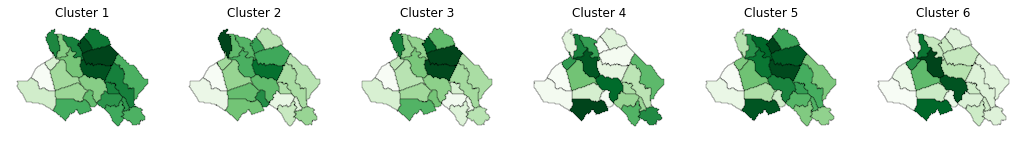

In [32]:
dtag_gdf2 = gpd.read_file('DTAG_districts.shp')
dtag_gdf2 = dtag_gdf2.loc[dtag_gdf2['DN']>0]
dtag_gdf2.reset_index(inplace=True)

#left branch
labels = [13, 31, 32, 19, 21, 22]

for i, cluster in enumerate(labels):
    avrg_profit = {}
    
    for col in results_cluster_medoid.columns:
        district_id = int(col.split('_')[1])
        val = results_cluster_medoid.loc[cluster][col]
        
        avrg_profit[district_id] = val
    
    dtag_gdf2['cluster_'+str(cluster)] = dtag_gdf2['DN'].map(avrg_profit)
    
fig, axes = plt.subplots(1,len(labels), figsize=(18,2))
row, col = 0,0

for i, cluster in enumerate(labels):
    name = 'cluster_' + str(cluster)
    dtag_gdf2.plot(column=name, legend=False, ax=axes[i], cmap='Greens', linewidth=0.3, edgecolor='black')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].axis('off')
    axes[i].set_title('Cluster ' + str(i+1))

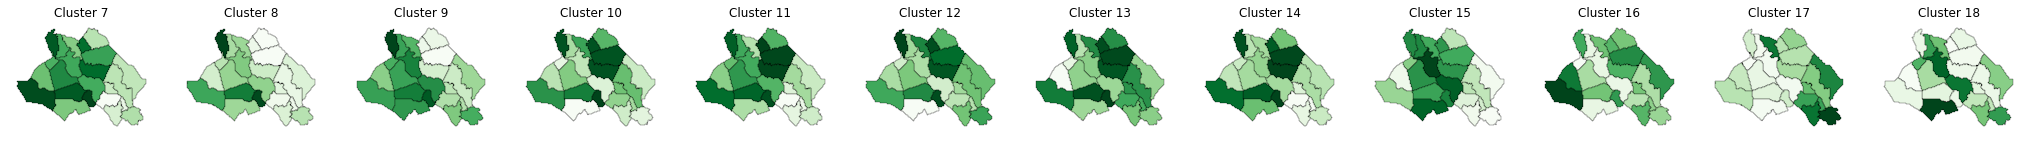

In [33]:
dtag_gdf2 = gpd.read_file('DTAG_districts.shp')
dtag_gdf2 = dtag_gdf2.loc[dtag_gdf2['DN']>0]
dtag_gdf2.reset_index(inplace=True)

#right branch
labels = [11, 33, 34, 27, 29, 30, 25, 26, 18, 23, 24, 10]

for i, cluster in enumerate(labels):
    avrg_profit = {}
    
    for col in results_cluster_medoid.columns:
        district_id = int(col.split('_')[1])
        val = results_cluster_medoid.loc[cluster][col]
        
        avrg_profit[district_id] = val
    
    dtag_gdf2['cluster_'+str(cluster)] = dtag_gdf2['DN'].map(avrg_profit)
    
fig, axes = plt.subplots(1,len(labels), figsize=(36,2))
row, col = 0,0

for i, cluster in enumerate(labels):
    name = 'cluster_' + str(cluster)
    dtag_gdf2.plot(column=name, legend=False, ax=axes[i], cmap='Greens', linewidth=0.3, edgecolor='black')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].axis('off')
    axes[i].set_title('Cluster ' + str(i+7))